In [1]:
import jax
import jax.numpy as jnp
from jax import vmap, grad

In [2]:
import sys
import os
sys.path.append("..")

import jax
jax.config.update("jax_enable_x64", True)
import equinox as eqx
import jax.numpy as jnp
from jax import vmap
import jax_dataloader as jdl
import networks
from utils import *

import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as jshard
import argparse
from optax.contrib import reduce_on_plateau

problem = "advection"
network = "fno_timestepping"
load_operator = False

data_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/data/"
hparams_path = "C:/Users/eirik/OneDrive - NTNU/5. klasse/prosjektoppgave/eirik_prosjektoppgave/hyperparameters/"
checkpoint_path = "C:/Users/eirik/orbax/checkpoints/"

scaled_data = jnp.load(data_path + problem + "_z_score.npz")
a_train_s = jnp.array(scaled_data["a_train_s"])
u_train_s = jnp.array(scaled_data["u_train_s"])
a_val_s = jnp.array(scaled_data["a_val_s"])
u_val_s = jnp.array(scaled_data["u_val_s"])

x_train_s = jnp.array(scaled_data["x_train_s"])
t_train_s = jnp.array(scaled_data["t_train_s"])

z_score_data = {
    "u_std" : scaled_data["u_std"].item(),
    "u_mean" : scaled_data["u_mean"].item(),
    "x_std" : scaled_data["x_std"].item(),
    "x_mean" : scaled_data["x_mean"].item(),
    "t_std" : scaled_data["t_std"].item(),
    "t_mean" : scaled_data["t_mean"].item()
}

# IMPORT WANTED NETWORK ARCHITECTURE
from networks.hno_fno_timestepping import *

with open(hparams_path +f"{network}_{problem}.json", "rb") as f:
    hparams_operator_net_dict = json.load(f) | z_score_data
    operator_net_hparams = OperatorHparams(**hparams_operator_net_dict)
#operator_net = OperatorNet(operator_net_hparams)
from networks.fno_timestepping import FNOTimeStepping as OperatorNet
operator_net = OperatorNet(operator_net_hparams)

# IMPORT HYPERPARAMETERS
with open(hparams_path + "energy_net_" + problem + '.json', "rb") as f:
    hparams_energy_net_dict = json.load(f) | z_score_data
    energy_net_hparams = EnergyNetHparams(**hparams_energy_net_dict)
    
energy_net = EnergyNet(energy_net_hparams)

model = HNO(energy_net = energy_net, operator_net= operator_net)

In [3]:
import matplotlib.pyplot as plt

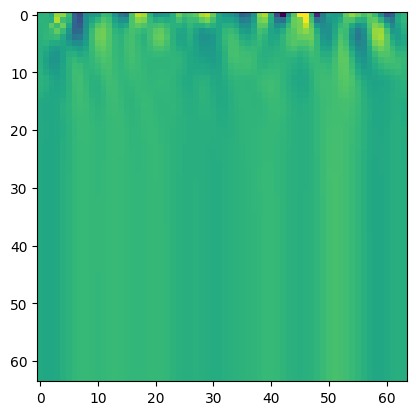

In [4]:
plt.imshow(model(a_train_s[0], x_train_s, t_train_s))

In [8]:
def F(u,u_x):
    return u**2 * u_x**3

def test(u,u_x):
    dF__du = grad(F)
    dF__du_x = grad(F, 1)
    
    u_xx = 12.3
    u_xxx = 4.5
    
    d2F__du2 = grad(dF__du)
    d2F__du_x2 = grad(dF__du_x, 1)
    d2F__du_x2_val = vmap(d2F__du_x2)(u, u_x)
    
    d2F__du_du_x_val = vmap(grad(dF__du,1))(u, u_x)
    
    d2F__du2_val, d3F__du_x_du2_val = vmap(value_and_grad(d2F__du2,1))(u, u_x)
    
    d3F__du_x2_du_val, d3F__du_x3_val = vmap(grad(d2F__du_x2, (0, 1)))(u, u_x)
    
    d2F__du_dx_val = d2F__du2_val * u_x  + d2F__du_du_x_val * u_xx
    d3F__du_x_dx2_val = d2F__du_du_x_val*u_xx +\
                        d2F__du_x2_val*u_xxx +\
                        d3F__du_x_du2_val*u_x**2 +\
                        2*d3F__du_x2_du_val*u_x*u_xx+\
                        d3F__du_x3_val * u_xx**2
                                
    𝒢δℋ = - d2F__du_dx_val + d3F__du_x_dx2_val
    return 𝒢δℋ.reshape(100,100)

In [9]:
u = random.uniform(random.key(0), (100, 100)).ravel()
u_x = random.uniform(random.key(1), (100, 100)).ravel()

In [25]:
def test2(u,u_x):
    d2F__du2 = vmap(grad(grad(F)))(u, u_x)
    
    dF__du_x = grad(F, 1)
    
    #d2F__dudu_x_and_d2F__du_x2  = grad(dF__du_x, (0,1))
    #values, hessian = vmap(value_and_grad(d2F__dudu_x_and_d2F__du_x2, (0,1)))(u, u_x)
    
    jacfwd(jacrev(dF__du_x))(u, u_x)
   
    #return 𝒢δℋ.reshape(100,100)

In [26]:
test2(u, u_x)

TypeError: Gradient only defined for scalar-output functions. Output had shape: (10000,).

In [33]:
from jax import jacfwd

In [35]:
ddf = jacrev(df, argnums=(0,1))

ddf(1.,1.)

((Array(2., dtype=float64, weak_type=True),
  Array(0., dtype=float64, weak_type=True)),
 (Array(0., dtype=float64, weak_type=True),
  Array(6., dtype=float64, weak_type=True)))

In [3]:
import matplotlib.pyplot as plt

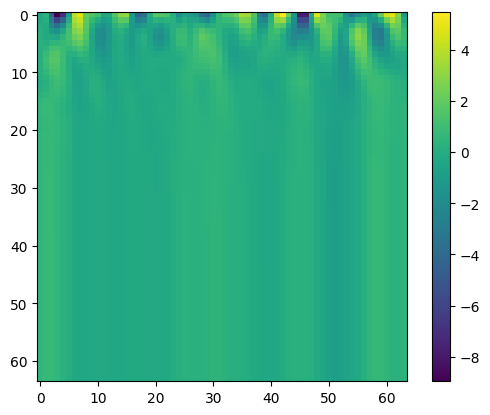

In [4]:
plt.imshow(operator_net.Dx(a_train_s[0], x_train_s, t_train_s))
plt.colorbar()

In [17]:
def pred1(a, x, t):
    u = lambda x : model.u(a, x, t) # u(x), function in x only (for convenience)
    u_x = grad(u) # u_x(x), function

    dFdu = lambda x : grad(model.F, 0)(u(x), u_x(x)) # ∂F/∂u(x), function
    dFdu_x = lambda x : grad(model.F, 1)(u(x), u_x(x)) # ∂F/∂u_x(x), function
    δℋ = lambda x : dFdu(x) - grad(dFdu_x)(x) # δℋ/δu(x), function
    
    𝒢δℋ = grad(δℋ)
    return -𝒢δℋ(x)

def pred2(a, x, t):
    u_func = lambda x : model.u(a, x, t) # u(x), function in x only (for convenience)
    u_x_func = grad(u_func) # u_x(x), function
    u_xx_func = grad(u_xx_func) # u_xx(x), function
    u_xxx_func = grad(u_xxx_func) # u_xxx(x), function
    
    u = u_func(x)
    u_x = u_x_func(x)
    u_xx = u_xx_func(x)
    u_xxx = u_xxx_func(x)
    
    dF__du = grad(model.F)
    dF__du_x = grad(model.F, 1)
    d2F__du2 = grad(dF__du)
    d2F__du_x2 = grad(dF__du_x, 1)
    d2F__du_du_x = grad(dF__du,1)
    d3F__du_x_du2 = grad(d2F__du2, 1)
    d3F__du_x2_du = grad(d2F__du_x2)
    d3F__du_x3 = grad(d2F__du_x2, 1)
    
    u_val = u(x)
    u_x_val = u_x(x)
    u_xx_val = u_xx(x)
    u_xxx_val = u_xxx(x)
    d2F__du_du_x_val = d2F__du_du_x(u_val, u_x_val)
    d2F__du_dx = d2F__du2(u_val, u_x_val) * u_x_val  + d2F__du_du_x_val * u_xx_val
    
    d3F__du_x_dx2 = d2F__du_du_x_val*u_xx_val +\
                                d2F__du_x2(u_val, u_x_val)*u_xxx_val +\
                                d3F__du_x_du2(u_val, u_x_val)*u_x_val**2 +\
                                2*d3F__du_x2_du(u_val, u_x_val)*u_x_val*u_xx_val+\
                                u_xx_val**2*d3F__du_x3(u_val, u_x_val)
                                 
    𝒢_δℋ__δu = - d2F__du_dx +  d3F__du_x_dx2
    return 𝒢_δℋ__δu

In [18]:
pred2(a_train_s[0], x_train_s[9], t_train_s[23])

Array(1102.95872925, dtype=float64)

In [13]:
pred1(a_train_s[0], x_train_s[9], t_train_s[23])

Array(1102.95872925, dtype=float64)

In [5]:
from jax import jacrev

In [7]:
jac = jacrev(operator_net, 1)(a_train_s[0], x_train_s, t_train_s)

Calling _call_fwd
Calling _call_bwd
(77, 64) (77, 64)


ValueError: Custom VJP bwd rule must produce an output with the same shape/dtypes as the args tuple of the primal function, but at output[0] the bwd rule produced an output of shape/dtype float64[64,64] corresponding to an input of shape/dtype float64[64].

In [6]:
grad(lambda x : jnp.sum(operator_net(a_train_s[0], x, t_train_s)))(x_train_s)

Calling _call_fwd
Calling _call_bwd
(77, 64) (77, 64)


ValueError: Custom VJP bwd rule must produce an output with the same shape/dtypes as the args tuple of the primal function, but at output[0] the bwd rule produced an output of shape/dtype float64[64,64] corresponding to an input of shape/dtype float64[64].

In [ ]:
plt.imshow(grad(lambda x : jnp.sum(operator_net(a_train_s[0], x, t_train_s)))(x_train_s))
plt.colorbar()

TypeError: differentiating with respect to argnums=1 requires at least 2 positional arguments to be passed by the caller, but got only 1 positional arguments.

In [12]:
from jax import custom_vjp

In [13]:
@custom_vjp
def f(x,y):
  print("called f!")
  return jnp.sin(x)

def f_fwd(x):
  print("called f_fwd!")
  return f(x), jnp.cos(x)

def f_bwd(cos_x, y_bar):
  print("called f_bwd!")
  return (cos_x * y_bar,)

f.defvjp(f_fwd, f_bwd)

In [15]:
grad(f)(3.0)

called f_fwd!
called f!
called f_bwd!


Array(-0.9899925, dtype=float64, weak_type=True)

In [7]:
model(a_train_s[0], x_train_s, t_train_s)

Array([[-1.80643006e-03,  2.39393064e-03, -4.44354239e-02, ...,
        -4.10217207e-01, -6.57032976e-02,  2.79321206e-03],
       [ 7.40632766e-04,  5.68877518e-04, -2.15252568e-02, ...,
        -2.98686882e-01, -4.92696199e-02,  1.35382505e-02],
       [-3.07513204e-04,  4.02039349e-03,  1.21845704e-01, ...,
        -2.03359287e-01, -8.13843012e-02, -9.08704960e-03],
       ...,
       [-4.65093808e-02, -5.98975685e-02, -6.15929016e-02, ...,
        -2.85561838e-02, -2.31480002e-02, -3.07789378e-02],
       [-4.65107457e-02, -5.98973406e-02, -6.15906867e-02, ...,
        -2.85558960e-02, -2.31483265e-02, -3.07801151e-02],
       [-4.65120516e-02, -5.98973938e-02, -6.15889383e-02, ...,
        -2.85555511e-02, -2.31484557e-02, -3.07809725e-02]],      dtype=float64)

In [7]:
import jax.numpy as jnp
from jax import lax

xs = jnp.array([1, 2, 3])
ys = jnp.array([3, 1, 4])

def scanned_fun(_, pair):
  x, y = pair
  return None, (x + y, (x, y))

_, (zs, xs) = lax.scan(scanned_fun, None, (xs, ys))
print(zs)  # [4, 3, 7]

[4 3 7]
